1. Install and Load Libraries

In [1]:
!pip install pmdarima

In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

import time
from datetime import datetime
from datetime import date, timedelta as td

warnings.filterwarnings('ignore')

1.1 Import and Preprocess the dataset

In [3]:
df = pd.read_csv('/content/dataset.csv')

In [4]:
df = df.rename(columns={'Country/Region': 'location',
                        'Date (yyyy/mm/dd)':'ds',
                        'Confirmed cases' : 'y',
                        'Death cases':'deaths',
                        'Recovered cases':'recovered'})

In [5]:
df['ds'] = pd.to_datetime(df['ds'])
df = df[df['location'] == 'Portugal']
df=df[['ds','y']]
df = df.set_index('ds')

In [6]:
dataset = df.loc['2020-08-01':'2020-11-25']

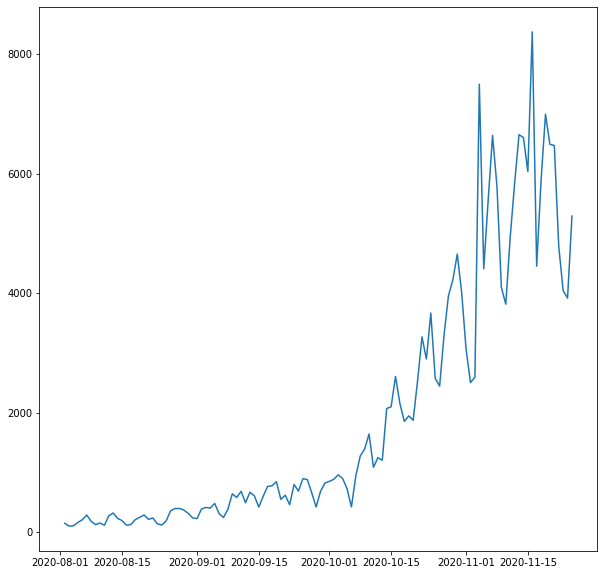

In [7]:
plt.figure(figsize=(10,10))
plt.plot(dataset.diff())
plt.savefig("Portugal's Cummulative Daily Cases")

In [8]:
dataset_diff = dataset.diff()
dataset_diff = dataset_diff.loc['2020-08-02' : '2020-11-25']
dataset = dataset.loc['2020-08-02' : '2020-11-25']

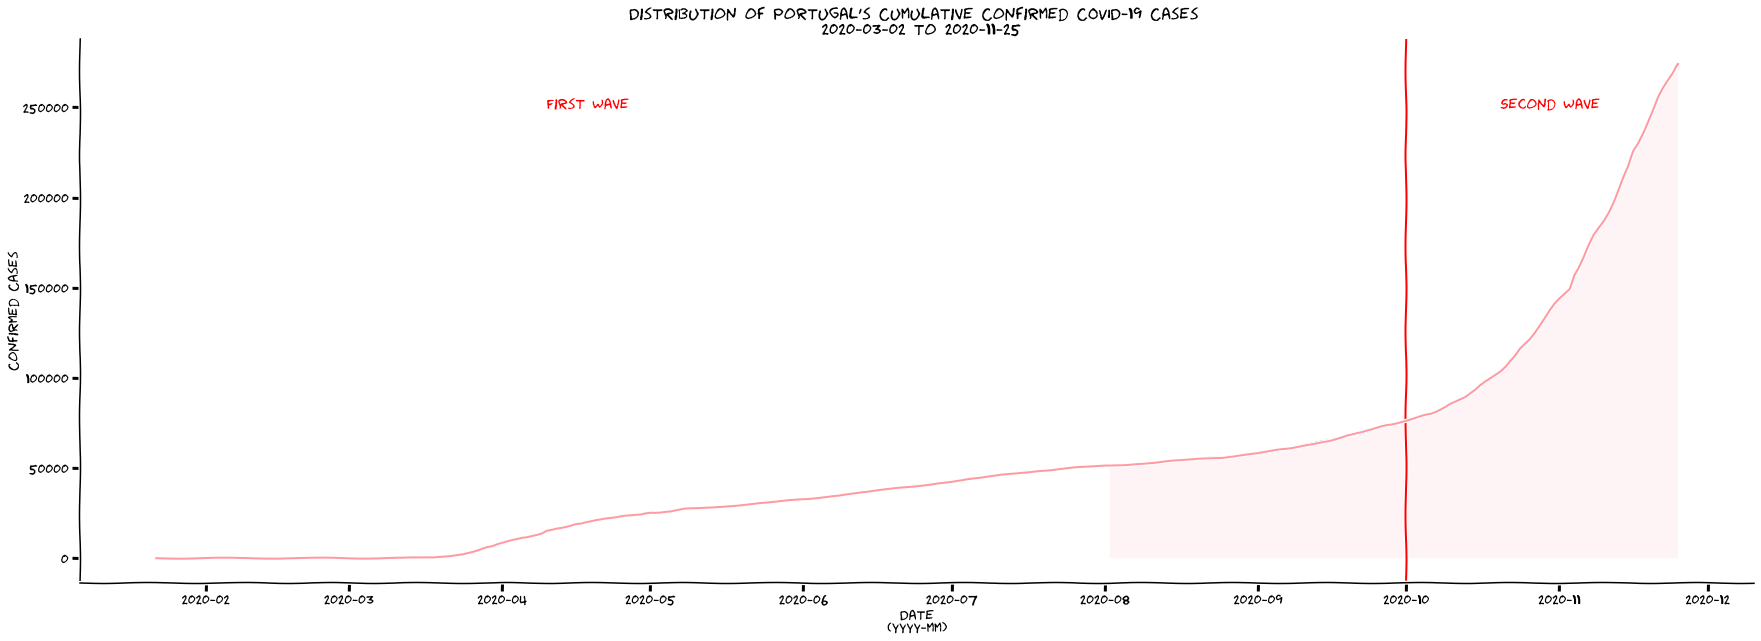

In [9]:
matplotlib.pyplot.xkcd(scale=0.5, length=100, randomness=2)
plt.figure(figsize=(30,10))


x = dataset.index
y = dataset['y']

ax = plt.subplot(111)
ax.plot(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Confirmed Cases')
ax.set_xlabel('Date\n(yyyy-mm)')
ax.set_title('Distribution of Portugal’s Cumulative Confirmed COVID-19 Cases \n 2020-03-02 to 2020-11-25')

ax.fill_between(x, y, facecolor='#FF9AA2', alpha=0.1)

plt.axvline(x = datetime(2020, 10, 1), color = 'r')


text1 = datetime(2020, 10, 20)
text2 = datetime(2020, 4, 10)
ax.text(text1, 250000, 'Second Wave', fontsize=15,  color='red')
ax.text(text2, 250000, 'First Wave', fontsize=15,  color='red')

plt.plot(df, color='#FF9AA2')

2. Modeling

2.1. ARIMAX / SARIMAX

In [10]:
start_date = '2020-11-15'

train = dataset.loc[dataset.index < pd.to_datetime(start_date)]
test = dataset.loc[dataset.index >= pd.to_datetime(start_date)]

In [11]:
model = SARIMAX(train, order=(0,2,0))

In [12]:
results = model.fit(disp=True)

In [13]:
model_diff = pm.auto_arima(train,trace=True, error_action='ignore', start_p=0,start_q=0,max_p=5,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=True)

print(model_diff.summary())

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=1646.091, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=1646.517, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=1647.672, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[1]             : AIC=1649.271, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[1]             : AIC=1650.711, Time=0.05 sec
 ARIMA(5,2,0)(0,0,0)[1]             : AIC=1652.732, Time=0.07 sec

Best model:  ARIMA(0,2,0)(0,0,0)[1]          
Total fit time: 0.230 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -822.046
Date:                Sat, 05 Dec 2020   AIC                           1646.091
Time:                        21:35:13   BIC                           1648.726
Sample:                             0   HQIC                          1647.158
                                - 105                

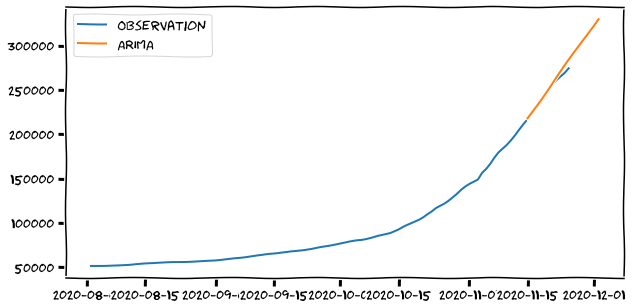

In [14]:
sarimax_prediction = results.predict(
    start='2020-11-15', end='2020-12-02', dynamic=False)
plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1,l2])

In [15]:
df_sarimax_prediction = pd.DataFrame(data=sarimax_prediction)
df_sarimax_prediction

,predicted_mean
2020-11-15,217868.0
2020-11-16,224470.0
2020-11-17,231072.0
2020-11-18,237674.0
2020-11-19,244276.0
2020-11-20,250878.0
2020-11-21,257480.0
2020-11-22,264082.0
2020-11-23,270684.0
2020-11-24,277286.0


2.2. Prophet

In [16]:
train['ds'] = train.index.values

In [17]:
m = Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
future = m.make_future_dataframe(periods=18)
prophet_prediction= m.predict(future)

In [19]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= start_date]

In [20]:
df_prophet_future = pd.DataFrame(data=prophet_future)
df_prophet_future

,yhat
ds,
2020-11-15,209495.227193
2020-11-16,213536.320102
2020-11-17,217601.165436
2020-11-18,222340.698020
2020-11-19,227004.316817
2020-11-20,231855.823491
2020-11-21,236748.333409
2020-11-22,240612.231457
2020-11-23,244653.324366


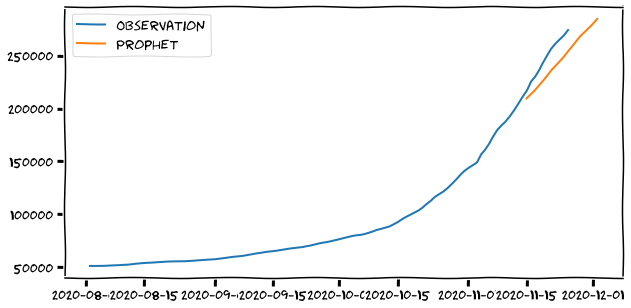

In [21]:
plt.figure(figsize=(10, 5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1,l2])

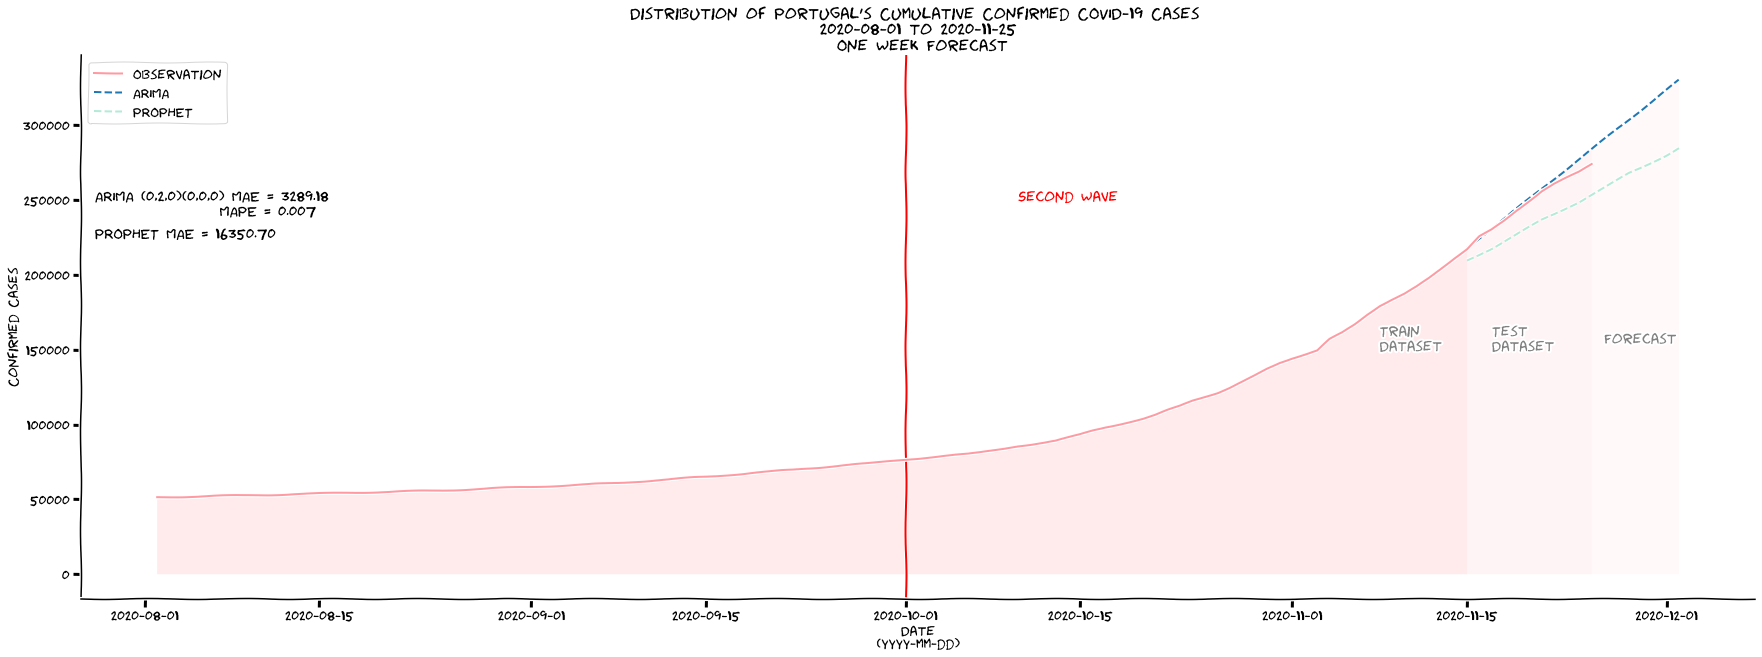

In [22]:
import time
from datetime import datetime
from datetime import date, timedelta as td
matplotlib.pyplot.xkcd(scale=0.5, length=100, randomness=2)
plt.figure(figsize=(30,10))


x = dataset.index
y1 = dataset['y']

l1, = plt.plot(dataset, label='Observation', color='#FF9AA2')
l2, = plt.plot(sarimax_prediction,'--', label='ARIMA')
l3, = plt.plot(prophet_future,'--', label='PROPHET',color='#B5EAD7')

ax = plt.subplot(111)
ax.plot(x, y)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Confirmed Cases')
ax.set_xlabel('Date\n(yyyy-mm-dd)')
ax.set_title('Distribution of Portugal’s Cumulative Confirmed COVID-19 Cases \n 2020-08-01 to 2020-11-25 \n One Week Forecast')

loc = dataset.loc['2020-08-02' : '2020-11-15']
ax.fill_between(loc.index, loc['y'], facecolor='#FF9AA2', alpha=0.2)
loc2 = df_sarimax_prediction.loc['2020-11-15' : '2020-11-25']
ax.fill_between(loc2.index, loc2['predicted_mean'], facecolor='#FF9AA2', alpha=0.1)
loc2 = df_sarimax_prediction.loc['2020-11-25' : '2020-12-02']
ax.fill_between(loc2.index, loc2['predicted_mean'], facecolor='#FF9AA2', alpha=0.05)

plt.axvline(x = datetime(2020, 10, 1), color = 'r')
text1 = datetime(2020, 10, 10)
ax.text(text1, 250000, 'Second Wave', fontsize=15,  color='red')


text1 = datetime(2020, 11, 8)
ax.text(text1, 150000, 'Train\nDataset', fontsize=15,  color='grey')


text1 = datetime(2020, 11, 17)
ax.text(text1, 150000, 'Test\nDataset', fontsize=15,  color='grey')

text1 = datetime(2020, 11, 26 )
ax.text(text1, 155000, 'Forecast', fontsize=15,  color='grey')

text1 = datetime(2020, 7, 28)
ax.text(text1, 250000, 'ARIMA (0,2,0)(0,0,0) MAE = 3289.18', fontsize=15,  color='black')
text1 = datetime(2020, 8,7)
ax.text(text1, 240000, 'MAPE = 0.007', fontsize=15,  color='black')
text1 = datetime(2020, 7, 28)
ax.text(text1, 225000, 'PROPHET MAE = 16350.70', fontsize=15,  color='black')

plt.legend(handles=[l1,l2,l3])
plt.plot(dataset, color='#FF9AA2')


2.3 XGBOOST

In [23]:
def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.y
    return X, y

featurize(dataset)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,2,8,3,6,215,31
1,3,8,3,0,216,32
2,4,8,3,1,217,32
3,5,8,3,2,218,32
4,6,8,3,3,219,32


In [24]:
X_train, y_train = featurize(
    dataset.loc[dataset.index < pd.to_datetime(start_date)])

X_test, y_test = featurize(
    dataset.loc[dataset.index >= pd.to_datetime(start_date)])

In [25]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [26]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

In [27]:
XGBOOST_model = XGBRegressor(n_estimators=7)

In [28]:
XGBOOST_model.fit(scaled_train, y_train,
                  eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
                  verbose=True)
XGBOOST_prediction = XGBOOST_model.predict(scaled_test)

[21:35:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:87487.7	validation_1-rmse:233708
[1]	validation_0-rmse:79314.8	validation_1-rmse:220055
[2]	validation_0-rmse:71925.9	validation_1-rmse:206545
[3]	validation_0-rmse:65233.9	validation_1-rmse:193991
[4]	validation_0-rmse:59181	validation_1-rmse:183544
[5]	validation_0-rmse:53691.2	validation_1-rmse:172781
[6]	validation_0-rmse:48729.6	validation_1-rmse:163917


In [29]:
print('XGBOOST MAE =', mean_absolute_error(XGBOOST_prediction, y_test))

XGBOOST MAE = 162930.90269886365


In [30]:
XGBOOST_prediction

array([84876.46, 84876.46, 84876.46, 84876.46, 84876.46, 84876.46,
       84876.46, 84876.46, 84876.46, 84876.46, 84876.46], dtype=float32)

2.4. Neural Network

In [31]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(scaled_train.shape[1], )))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=220, verbose=1)
NN_prediction = NN_model.predict(scaled_test)

Epoch 1/220
4/4 [==============================] - 0s 36ms/step - loss: 87290.3828 - val_loss: 247808.4531
Epoch 2/220
4/4 [==============================] - 0s 6ms/step - loss: 87290.3203 - val_loss: 247808.3594
Epoch 3/220
4/4 [==============================] - 0s 6ms/step - loss: 87290.2969 - val_loss: 247808.3594
Epoch 4/220
4/4 [==============================] - 0s 6ms/step - loss: 87290.2578 - val_loss: 247808.3438
Epoch 5/220
4/4 [==============================] - 0s 6ms/step - loss: 87290.2188 - val_loss: 247808.4062
Epoch 6/220
4/4 [==============================] - 0s 5ms/step - loss: 87290.1875 - val_loss: 247808.4531
Epoch 7/220
4/4 [==============================] - 0s 6ms/step - loss: 87290.1562 - val_loss: 247808.5469
Epoch 8/220
4/4 [==============================] - 0s 5ms/step - loss: 87290.1172 - val_loss: 247808.5938
Epoch 9/220
4/4 [==============================] - 0s 5ms/step - loss: 87290.0703 - val_loss: 247808.5625
Epoch 10/220
4/4 [===========================

In [32]:
print('NN MAE =', mean_absolute_error(NN_prediction, y_test))

NN MAE = 246915.18045876242


3. Overview

Text(0.5, 1.0, 'NN')

<Figure size 3600x3600 with 0 Axes>

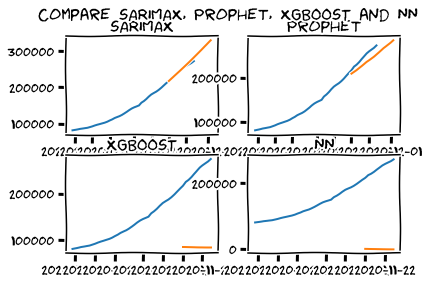

In [33]:
XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index

plt.figure(figsize=(50,50))
fig,axs = plt.subplots(2,2)
fig.suptitle('Compare SARIMAX, Prophet, XGBOOST and NN')
axs[0, 0].plot(dataset.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(dataset.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(dataset.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(dataset.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")
